This is the final code for the Markov implementation.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as DT
import yfinance as yf
import numpy as np 
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
import pandas_market_calendars as mcal
import datetime
from mpl_toolkits.mplot3d import axes3d
import scipy as sp
import scipy.interpolate
from scipy.stats import norm
import math
from nelson_siegel_svensson.calibrate import calibrate_ns_ols 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from statsmodels.tsa.statespace.kalman_filter import KalmanFilter
import numpy as np
from scipy.stats import norm, skewnorm

In [2]:
final_date = pd.to_datetime('2024-09-26')
start_date = pd.to_datetime('2024-01-01')

def load_data(file_path):
    data = pd.read_csv(file_path)
    data.index = pd.to_datetime(data['Date'], format='%m/%d/%Y')
    data['Price'] = data['Price'].str.replace(',', '').astype(float)
    data['Log Return'] = np.log(data['Price'] / data['Price'].shift(1))
    data = data.dropna(subset=['Log Return'])
    data = data[data.index > "2014-01-01"]
    return data

file_path = "../Data CSV/SMI Historical Data.csv"
smi = load_data(file_path)

file_path = "../Data CSV/S&P 500 Historical Data.csv"
sp500 = load_data(file_path)

file_path = "../Data CSV/Euro Stoxx 50 Historical Data.csv"
stoxx50 = load_data(file_path)

common_dates = list(set(stoxx50.index).intersection(set(smi.index).intersection(set(sp500.index))))
## losing data on dates, simulation also assuming common dates, losing about 14% data
print("Data Loss:", (3*len(common_dates))/(len(stoxx50)+len(smi)+len(sp500)))

def load_data(file_path):
    data = pd.read_csv(file_path)
    data.index = pd.to_datetime(data['Date'], format='%m/%d/%Y')
    data = data[data.index.isin(common_dates)]
    data['Price'] = data['Price'].str.replace(',', '').astype(float)
    data['Log Return'] = np.log(data['Price'] / data['Price'].shift(1))
    data.drop(columns=["Change %"], errors = "Ignore", inplace = True)
    data = data.dropna(subset=['Log Return'])
    return data

file_path = "../Data CSV/SMI Historical Data.csv"
smi = load_data(file_path)

file_path = "../Data CSV/S&P 500 Historical Data.csv"
sp500 = load_data(file_path)

file_path = "../Data CSV/Euro Stoxx 50 Historical Data.csv"
stoxx50 = load_data(file_path)

returns = pd.DataFrame({
    'SMI': smi['Log Return'],
    'STOXX50': stoxx50['Log Return'],
    'SP500': sp500['Log Return']
}).dropna()

chf = pd.read_csv("../Data CSV/USD_CHF Historical Data.csv")
chf.index = pd.DatetimeIndex(chf["Date"])
eur = pd.read_csv("../Data CSV/USD_EUR Historical Data.csv")
eur.index = pd.DatetimeIndex(eur["Date"])

## Divide to convert chf to usd, multiply for other way 

dates = pd.bdate_range(start=start_date,end=final_date)

interest_rates = pd.read_excel("../Data CSV/US Interest Rates.xlsx")
interest_rates.columns = interest_rates.columns.str.strip()
interest_rates = interest_rates.dropna(subset=["United States Treasury 10-YR Rates"])
interest_rates["United States Treasury 10-YR Rates"] = pd.to_numeric(
    interest_rates["United States Treasury 10-YR Rates"], errors="coerce"
)
interest_rates.index = pd.DatetimeIndex(interest_rates["Dates"])
full_date_range = pd.date_range(start=interest_rates.index.min(), end=interest_rates.index.max())
interest_rates = interest_rates.reindex(full_date_range).ffill()
interest_rates.index.name = "Dates"
interest_rates.head()

r = interest_rates["United States Treasury 10-YR Rates"].dropna()
r = np.log(1+0.01*r)

sp500_init_level = 3977
stoxx_init_level_local = 4164
smi_init_level_local = 10786
##Double checked
dt = 1/252


Data Loss: 0.9684005833738454


In [3]:
def price_barrier_reverse_convertible(start_date, price_paths ):
    final_date = pd.to_datetime('2024-09-26')
    start_date = pd.to_datetime(start_date)    
    T = (final_date - start_date).days / 365.0

    eur_usd = eur["Price"][start_date] 
    chf_usd = chf["Price"][start_date] 
    stoxx_init_level = stoxx_init_level_local / eur_usd
    smi_init_level = smi_init_level_local / chf_usd

    
    sp500_barrier = sp500_init_level * 0.65
    stoxx_barrier = stoxx_init_level * 0.65
    smi_barrier = smi_init_level * 0.65
    
    payment_dates = [start_date + pd.DateOffset(months=3*i) for i in range(1, 5)]
    payment_dates = [d for d in payment_dates if d <= final_date]
    
    risk_free_rate = r[r.index <= start_date].iloc[-1]
    
    pv_interest = sum([
        1000 * 0.025 * math.exp(-risk_free_rate * ((payment_date - start_date).days / 365.0))
        for payment_date in payment_dates
    ])
    
    discount_factor_maturity = math.exp(-risk_free_rate * T)
    
    sim_dates = pd.bdate_range(start=start_date, end=final_date)
    sim_length = len(sim_dates)
    
    num_sims = len(price_paths['SMI'])
    
    prices = np.zeros(num_sims)
    
    for i in range(num_sims):
        sim_SMI = np.array(price_paths['SMI'][i][:sim_length])
        sim_SP500 = np.array(price_paths['SP500'][i][:sim_length])
        sim_STOXX50 = np.array(price_paths['STOXX50'][i][:sim_length])
        
        barrier_breached = (
            (sim_SMI < smi_barrier).any() or
            (sim_SP500 < sp500_barrier).any() or
            (sim_STOXX50 < stoxx_barrier).any()
        )
        
        if not barrier_breached:
            pv_redemption = 1000 * discount_factor_maturity
        else:
            final_SMI = sim_SMI[-1]
            final_SP500 = sim_SP500[-1]
            final_STOXX50 = sim_STOXX50[-1]
            
            perf_SMI = final_SMI / smi_init_level
            perf_SP500 = final_SP500 / sp500_init_level
            perf_STOXX50 = final_STOXX50 / stoxx_init_level
            
            worst_perf = min(perf_SMI, perf_SP500, perf_STOXX50, 1)
            pv_redemption = 1000 * discount_factor_maturity * worst_perf
        
        price = pv_interest + pv_redemption
        prices[i] = price
    
    return prices

In [4]:
def simulate_gbm(start_date, n_simulations = 100000, verbose = False, h_percentage_change = {'SMI': 1.0,'STOXX50':1.0, 'SP500':1.0}):
    dt = 1 / 252  
    mu = {}
    sigma = {}
    
    risk_free_rate = r[r.index <= start_date].iloc[-1]
   
    # risk_free_rate = np.log(1+0.01*r[r.index <= start_date].iloc[-1])
    
    for index in ['SMI', 'STOXX50', 'SP500']:
        mean_return = risk_free_rate
        variance = returns[index].var()*252
        mu[index] = mean_return
        sigma[index] = np.sqrt(variance)
    
    corr_matrix = returns.corr()
    chol_matrix = np.linalg.cholesky(corr_matrix)
    
    n_timesteps = len(dates)
    
    Z = np.random.normal(size=(n_timesteps, n_simulations, 3))
    Z_flat = Z.reshape(-1, 3)
    Z_correlated_flat = Z_flat @ chol_matrix.T
    Z_correlated = Z_correlated_flat.reshape(n_timesteps, n_simulations, 3)
    
    initial_prices = {
        'SMI': smi[smi.index >= start_date]['Price'].iloc[-1],
        'STOXX50': stoxx50[stoxx50.index >= start_date]['Price'].iloc[-1],
        'SP500': sp500[sp500.index >= start_date]['Price'].iloc[-1]
    }

    for i in initial_prices:
        initial_prices[i] *= h_percentage_change.get(i)
    
    price_paths = {
        'SMI': np.zeros((n_timesteps + 1, n_simulations)),
        'STOXX50': np.zeros((n_timesteps + 1, n_simulations)),
        'SP500': np.zeros((n_timesteps + 1, n_simulations))
    }
    
    for index in ['SMI', 'STOXX50', 'SP500']:
        price_paths[index][0] = initial_prices[index]
    
    for i in range(1, n_timesteps + 1):
        for idx, index in enumerate(['SMI', 'STOXX50', 'SP500']):
            drift_term = (mu[index] - 0.5 * sigma[index] ** 2)*dt
            diffusion_term = sigma[index] * np.sqrt(dt) * Z_correlated[i - 1, :, idx]
            price_paths[index][i] = price_paths[index][i - 1] * np.exp(drift_term + diffusion_term)
    
    for index in ['SMI', 'STOXX50', 'SP500']:
        price_paths[index]= price_paths[index].transpose()
    T = (final_date-start_date).days/352
    if not verbose:
        return price_paths
    
    print()
    for i in mu:
        print(i, "mu:", mu.get(i), "std:", sigma.get(i))
        print(i, "expected mu:", mu.get(i)*T, "std:", sigma.get(i)*np.sqrt(T))
        print()
    for i in price_paths:
        print(i)
        paths = price_paths.get(i)
        print("| Mean Price:", np.mean([i[-1] for i in paths]), "| Mean Return:", np.mean([i[-1] for i in paths])/paths[0][0], "| SD of Return:", np.std(np.array([i[-1] for i in paths])/paths[0][0]))
    return price_paths

In [5]:
# Define the negative log-likelihood function. Here we fix theta to be 3.84%, according to US Long-Term Monthly Rate Analysis
def negative_log_likelihood_fixed_theta(params, r_df, theta=0.0384):
    kappa, sigma_r = params
    if kappa <= 0 or sigma_r <= 0:
        return np.inf
    log_likelihood = 0
    rates = r_df.values
    dates = r_df.index
    for t in range(len(rates) - 1):
        r_t = rates[t]
        r_t1 = rates[t + 1]
        dr = r_t1 - r_t
        dt_days = (dates[t + 1] - dates[t]).days
        dt = dt_days / 252
        if dt <= 0:
            continue
        mean_increment = kappa * (theta - r_t) * dt
        variance_increment = sigma_r**2 * r_t * dt
        if variance_increment <= 0:
            return np.inf
        likelihood_t = -0.5 * np.log(2 * np.pi * variance_increment) - 0.5 * (
            (dr - mean_increment) ** 2 / variance_increment
        )
        log_likelihood += likelihood_t
    return -log_likelihood

# Initial guesses and bounds for kappa and sigma_r
initial_vals = [0.1, np.std(r.values)]
bounds = ((1e-5, None), (1e-5, None))

# Optimization with fixed theta
result = scipy.optimize.minimize(
    negative_log_likelihood_fixed_theta, initial_vals, args=(r,dt), bounds=bounds, method="L-BFGS-B"
)

kappa, sigma_r = result.x
theta = np.log(1+0.0384)
print("Fitted Parameters with Theta Fixed at 0.0384:")
print("kappa:", kappa)
print("sigma_r:", sigma_r)
print("theta:", theta)



Fitted Parameters with Theta Fixed at 0.0384:
kappa: 1e-05
sigma_r: 0.05580666435095845
theta: 0.037681066967688484


In [6]:
def simulate_price_paths_with_CIR(start_date, n_simulations, h_percentage_change = {'SMI': 1.0,'STOXX50':1.0, 'SP500':1.0}):
    start_date = pd.to_datetime(start_date)
    final_date = pd.to_datetime('2024-09-26')
  
    sim_dates = pd.bdate_range(start=start_date, end=final_date)
    n_timesteps = len(sim_dates)

    corr_matrix = returns[indices].corr()
    chol_matrix = np.linalg.cholesky(corr_matrix)

    Z = np.random.normal(size=(n_timesteps, n_simulations, len(indices)))
    Z_flat = Z.reshape(-1, len(indices))
    Z_correlated_flat = Z_flat @ chol_matrix.T
    Z_correlated = Z_correlated_flat.reshape(n_timesteps, n_simulations, len(indices))
    initial_prices = {}
    
    for index in indices:
        initial_prices[index] = price_data[index]['Price'][price_data[index].index >= start_date].iloc[-1]
    for i in indices:
        initial_prices[i] *= h_percentage_change.get(i)

    price_paths = {index: np.zeros((n_timesteps + 1, n_simulations)) for index in ['SMI', 'STOXX50', 'SP500']}
    for index in ['SMI', 'STOXX50', 'SP500']:
        price_paths[index][0] = initial_prices[index]
    
    initial_rate = r[start_date]

    r_paths = np.zeros((n_timesteps + 1, n_simulations))
    # r_paths = r_paths.T  # Shape: (n_simulations, n_timesteps + 1)
    r_paths[0, :] = initial_rate
    
    
    for i in range(1, n_timesteps + 1):
        Z_r = np.random.normal(size=n_simulations)
        r_t_prev = r_paths[i - 1]
        dr = kappa * (theta - r_t_prev) * dt + sigma_r * np.sqrt(r_t_prev * dt) * Z_r
        r_paths[i] = np.maximum(r_t_prev + dr, 0)
        
    
        for idx, index in enumerate(['SMI', 'STOXX50', 'SP500']):
            drift_term = (r_paths[i] - 0.5 * sigma[index] ** 2) * dt
            # drift_term = (np.log(1+r_paths[i]*0.01) - 0.5 * sigma[index] ** 2) * dt
            diffusion_term = sigma[index] * np.sqrt(dt) * Z_correlated[i - 1, :, idx]
            price_paths[index][i] = price_paths[index][i - 1] * np.exp(drift_term + diffusion_term)
    
    for index in ['SMI', 'STOXX50', 'SP500']:
        price_paths[index] = price_paths[index].transpose()
    return price_paths, r_paths


In [7]:
# Define file paths for GDP and CPI data
files = {
    "Eurozone": {
        "GDP": "../Data CSV/GDP Real USD Eurozone Quarterly Economic Time Series Profile.xls",
        "CPI": "../Data CSV/CPI Y o Y Eurozone Monthly Economic Time Series Profile.xls",
    },
    "Switzerland": {
        "GDP": "../Data CSV/GDP Real USD Switzerland Quarterly Economic Time Series Profile.xls",
        "CPI": "../Data CSV/CPI Y o Y Switzerland Monthly Economic Time Series Profile.xls",
    },
    "USA": {
        "GDP": "../Data CSV/GDP Real USD United States of America Quarterly Economic Time Series Profile.xls",
        "CPI": "../Data CSV/CPI Y o Y United States of America Monthly Economic Time Series Profile.xls",
    },
}

store = {}
for country, paths in files.items():
    print(country)

    # Read GDP and CPI data
    gdp_df = pd.read_excel(paths["GDP"], sheet_name="Series Values", header=6)
    cpi_df = pd.read_excel(paths["CPI"], sheet_name="Series Values", header=6)

    # Ensure 'Period' is in datetime format
    gdp_df['Period'] = pd.to_datetime(gdp_df['Period'], errors='coerce')
    cpi_df['Period'] = pd.to_datetime(cpi_df['Period'], errors='coerce')

    # Select relevant columns
    gdp_df = gdp_df[['Period', 'Y-o-Y Change %']].rename(columns={'Y-o-Y Change %': 'GDP_YoY%'})
    cpi_df = cpi_df[["Period", "Value"]].rename(columns={'Value': 'CPI_YoY%'})

    # Define the date range as pandas Timestamps
    start_date = pd.Timestamp("2000-03-31")
    end_date = pd.Timestamp("2024-08-31")

    # Filter dataframes within the date range
    gdp_df = gdp_df[(gdp_df['Period'] >= start_date) & (gdp_df['Period'] <= end_date)]
    cpi_df = cpi_df[(cpi_df['Period'] >= start_date) & (cpi_df['Period'] <= end_date)]

    print("GDP DATA FOR " + country)
    print(gdp_df)
    print("CPI DATA FOR " + country)
    print(cpi_df)

    # Merge GDP and CPI data
    store[country] = pd.merge(gdp_df, cpi_df, on='Period', how='outer')

    print(store[country])


Eurozone
GDP DATA FOR Eurozone
       Period GDP_YoY%
1  2024-06-30    0.006
2  2024-03-31   0.0046
3  2023-12-31   0.0063
4  2023-09-30   0.0047
5  2023-06-30   0.0103
..        ...      ...
94 2001-03-31   0.0512
95 2000-12-31   0.0333
96 2000-09-30   0.0392
97 2000-06-30   0.0467
98 2000-03-31   0.0426

[98 rows x 2 columns]
CPI DATA FOR Eurozone
        Period  CPI_YoY%
2   2024-08-31      2.17
3   2024-07-31      2.58
4   2024-06-30      2.52
5   2024-05-31      2.57
6   2024-04-30      2.37
..         ...       ...
291 2000-07-31      2.09
292 2000-06-30      2.14
293 2000-05-31      1.76
294 2000-04-30      1.71
295 2000-03-31      1.96

[294 rows x 2 columns]
        Period GDP_YoY%  CPI_YoY%
0   2000-03-31   0.0426      1.96
1   2000-04-30      NaN      1.71
2   2000-05-31      NaN      1.76
3   2000-06-30   0.0467      2.14
4   2000-07-31      NaN      2.09
..         ...      ...       ...
289 2024-04-30      NaN      2.37
290 2024-05-31      NaN      2.57
291 2024-06-30    

In [8]:
store["USA"]['GDP_YoY%'] = store["USA"]['GDP_YoY%']\
    .str.replace('%', '', regex=False)\
    .str.replace(r'\((.*?)\)', r'-\1', regex=True)\
    .astype(float) / 100


# %%
store["USA"]['GDP_YoY%'] = store["USA"]['GDP_YoY%'].ffill()
store["Eurozone"]['GDP_YoY%'] = store["Eurozone"]['GDP_YoY%'].ffill()
store["Switzerland"]['GDP_YoY%'] = store["Switzerland"]['GDP_YoY%'].ffill()

print(store["Eurozone"])
print(store["USA"])
print(store["Switzerland"])


        Period  GDP_YoY%  CPI_YoY%
0   2000-03-31    0.0426      1.96
1   2000-04-30    0.0426      1.71
2   2000-05-31    0.0426      1.76
3   2000-06-30    0.0467      2.14
4   2000-07-31    0.0467      2.09
..         ...       ...       ...
289 2024-04-30    0.0046      2.37
290 2024-05-31    0.0046      2.57
291 2024-06-30    0.0060      2.52
292 2024-07-31    0.0060      2.58
293 2024-08-31    0.0060      2.17

[294 rows x 3 columns]
        Period  GDP_YoY%  CPI_YoY%
0   2000-03-31    0.0422      3.76
1   2000-04-30    0.0422      3.07
2   2000-05-31    0.0422      3.19
3   2000-06-30    0.0524      3.73
4   2000-07-31    0.0524      3.66
..         ...       ...       ...
289 2024-04-30    0.0290      3.36
290 2024-05-31    0.0290      3.27
291 2024-06-30    0.0304      2.97
292 2024-07-31    0.0304      2.89
293 2024-08-31    0.0304      2.53

[294 rows x 3 columns]
        Period  GDP_YoY%  CPI_YoY%
0   2000-03-31    0.0432      1.48
1   2000-04-30    0.0432      1.40
2   200

/var/folders/29/j6zpgq394917k8prm4sg190h0000gn/T/ipykernel_57838/3379459302.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  store["Eurozone"]['GDP_YoY%'] = store["Eurozone"]['GDP_YoY%'].ffill()
/var/folders/29/j6zpgq394917k8prm4sg190h0000gn/T/ipykernel_57838/3379459302.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  store["Switzerland"]['GDP_YoY%'] = store["Switzerland"]['GDP_YoY%'].ffill()


In [9]:
Eurozone_data = store["Eurozone"][['GDP_YoY%', 'CPI_YoY%', "Period"]].dropna()
usa_data = store["USA"][['GDP_YoY%', 'CPI_YoY%', "Period"]].dropna()
Switzerland_data = store["Switzerland"][['GDP_YoY%', 'CPI_YoY%', "Period"]].dropna()

In [10]:
import numpy as np
from scipy.stats import gamma, dirichlet, norm

def bayesian_hmm_gibbs_sampler(Y, K, num_iter, burn_in):
    T = len(Y)
    
    # Hyperparameters
    alpha = np.ones(K)  # For initial state distribution
    beta = np.ones((K, K))  # For transition probabilities
    mu_0 = 0
    sigma_0_squared = 10**2
    a_0 = 1
    b_0 = 1

    # Initial values
    pi = dirichlet.rvs(alpha)[0]
    A = np.array([dirichlet.rvs(beta_row)[0] for beta_row in beta])
    mu = np.random.normal(mu_0, np.sqrt(sigma_0_squared), size=K)
    sigma_squared = 1 / gamma.rvs(a_0, scale=1/b_0, size=K)
    S = np.random.choice(K, size=T)

    # Storage for samples
    samples = {
        'pi': [],
        'A': [],
        'mu': [],
        'sigma_squared': [],
        'S': []
    }

    for it in range(num_iter):
        # 1. Sample Hidden States S using Forward-Backward and Backward Sampling
        alpha_t = np.zeros((T, K))
        beta_t = np.zeros((T, K))
        scale_factors = np.zeros(T)

        # Forward pass
        for t in range(T):
            if t == 0:
                alpha_t[t] = pi * norm.pdf(Y[t], mu, np.sqrt(sigma_squared))
            else:
                alpha_t[t] = (alpha_t[t-1] @ A) * norm.pdf(Y[t], mu, np.sqrt(sigma_squared))
            # Normalize
            scale = np.sum(alpha_t[t])
            alpha_t[t] /= scale
            scale_factors[t] = scale

        # Backward pass
        beta_t[T-1] = 1
        for t in range(T-2, -1, -1):
            beta_t[t] = (A @ (norm.pdf(Y[t+1], mu, np.sqrt(sigma_squared)) * beta_t[t+1]))
            beta_t[t] /= np.sum(beta_t[t])

        # Sample S_t
        S_t_prob = alpha_t * beta_t
        S_t_prob /= np.sum(S_t_prob, axis=1, keepdims=True)
        S = np.array([np.random.choice(K, p=S_t_prob[t]) for t in range(T)])

        # 2. Sample Parameters
        # Sample pi
        m = np.zeros(K)
        m[S[0]] += 1
        pi = dirichlet.rvs(alpha + m)[0]

        # Sample A
        n_ij = np.zeros((K, K))
        for t in range(1, T):
            n_ij[S[t-1], S[t]] += 1
        for i in range(K):
            A[i] = dirichlet.rvs(beta[i] + n_ij[i])[0]

        # Sample mu and sigma_squared
        for j in range(K):
            Y_j = Y[S == j]
            n_j = len(Y_j)
            if n_j > 0:
                mean_Y_j = np.mean(Y_j)
                sum_squared_diff = np.sum((Y_j - mean_Y_j)**2)

                a_post = a_0 + n_j / 2
                b_post = b_0 + 0.5 * np.sum((Y_j - mu[j])**2)
                sigma_squared[j] = 1 / gamma.rvs(a_post, scale=1/b_post)

                sigma_mu_j_squared = 1 / (n_j / sigma_squared[j] + 1 / sigma_0_squared)
                mu_j_mean = sigma_mu_j_squared * (n_j * mean_Y_j / sigma_squared[j] + mu_0 / sigma_0_squared)
                mu[j] = np.random.normal(mu_j_mean, np.sqrt(sigma_mu_j_squared))
            else:
                sigma_squared[j] = 1 / gamma.rvs(a_0, scale=1/b_0)
                mu[j] = np.random.normal(mu_0, np.sqrt(sigma_0_squared))

        # Store samples after burn-in
        if it >= burn_in:
            samples['pi'].append(pi.copy())
            samples['A'].append(A.copy())
            samples['mu'].append(mu.copy())
            samples['sigma_squared'].append(sigma_squared.copy())
            samples['S'].append(S.copy())

    return samples

In [11]:
import numpy as np
from scipy.stats import norm, skewnorm

def particle_filter(Y, pi, A, emission_params, num_particles, ess_threshold=0.5):
    """
    Implements a particle filter for an HMM with ESS cutoff to prevent degeneracy.

    Parameters:
    - Y: Observed data sequence (array of length T).
    - pi: Initial state distribution (array of length K).
    - A: Transition matrix (K x K array).
    - emission_params: Dictionary containing emission parameters.
        - For Gaussian emissions: {'mu': array, 'sigma': array}
        - For skew-normal emissions: {'xi': array, 'omega': array, 'alpha': array}
    - num_particles: Number of particles to use in the filter.
    - ess_threshold: Fraction of the number of particles to trigger resampling (default is 0.5).

    Returns:
    - particles: Array of particles at each time step (T x num_particles).
    - weights: Array of weights at each time step (T x num_particles).
    - estimated_states: Estimated state sequence (array of length T).
    """
    T = len(Y)
    K = len(pi)
    particles = np.zeros((T, num_particles), dtype=int)
    weights = np.zeros((T, num_particles))
    
    # Initialize particles and weights
    particles[0] = np.random.choice(K, size=num_particles, p=pi)
    if 'mu' in emission_params:
        # Gaussian emissions
        emission_probs = norm.pdf(Y[0], loc=emission_params['mu'][particles[0]], scale=emission_params['sigma'][particles[0]])
    elif 'xi' in emission_params:
        # Skew-normal emissions
        emission_probs = skewnorm.pdf(Y[0], a=emission_params['alpha'][particles[0]],
                                      loc=emission_params['xi'][particles[0]],
                                      scale=emission_params['omega'][particles[0]])
    else:
        raise ValueError("Emission parameters are not properly defined.")
    
    weights[0] = emission_probs
    weights[0] /= np.sum(weights[0])  # Normalize weights
    
    for t in range(1, T):
        # Calculate ESS
        ess = 1.0 / np.sum(weights[t-1] ** 2)
        
        # Resample if ESS falls below the threshold
        if ess < ess_threshold * num_particles:
            indices = np.random.choice(num_particles, size=num_particles, p=weights[t-1])
            particles[t-1] = particles[t-1][indices]
            weights[t-1] = np.ones(num_particles) / num_particles  # Reset weights to uniform after resampling
        
        particles_t_minus_1 = particles[t-1]
        
        # Predict step: sample next state for each particle
        particles[t] = np.array([np.random.choice(K, p=A[particles_t_minus_1[i]]) for i in range(num_particles)])
        
        # Update weights based on observation likelihood
        if 'mu' in emission_params:
            # Gaussian emissions
            emission_probs = norm.pdf(Y[t], loc=emission_params['mu'][particles[t]], scale=emission_params['sigma'][particles[t]])
        elif 'xi' in emission_params:
            # Skew-normal emissions
            emission_probs = skewnorm.pdf(Y[t], a=emission_params['alpha'][particles[t]],
                                          loc=emission_params['xi'][particles[t]],
                                          scale=emission_params['omega'][particles[t]])
        weights[t] = emission_probs
        weights[t] /= np.sum(weights[t])  # Normalize weights
    
    # Estimate states (e.g., using the most probable particle at each time)
    estimated_states = np.zeros(T, dtype=int)
    for t in range(T):
        # You can choose different methods for state estimation
        # Here, we use the state with the highest total weight
        counts = np.bincount(particles[t], weights=weights[t])
        estimated_states[t] = np.argmax(counts)
    
    return particles, weights, estimated_states

In [12]:
samples = {}

Y_USA = store["USA"]['CPI_YoY%'].values
K = 2
num_iter = 5000
burn_in = 1000

samples["USA"] = bayesian_hmm_gibbs_sampler(Y_USA, K, num_iter, burn_in)


Y_Eurozone = store["Eurozone"]['CPI_YoY%'].values
K = 2
num_iter = 5000
burn_in = 1000

samples["Eurozone"] = bayesian_hmm_gibbs_sampler(Y_Eurozone, K, num_iter, burn_in)


Y_Switzerland = store["USA"]['CPI_YoY%'].values
K = 2
num_iter = 5000
burn_in = 1000

samples["Switzerland"] = bayesian_hmm_gibbs_sampler(Y_Switzerland, K, num_iter, burn_in)


In [13]:
samplenum = len(samples["USA"]['S'])
T = len(Y_USA)



for s in range(samplenum):
    mu_s = samples["USA"]['mu'][s]  # Emission means for sample s (mean of shape (K,))
    S_s = samples["USA"]['S'][s]    # Hidden states for sample s (mean of shape (T,))
    
# Compute the posterior predictive mean for each time point
Y_pred_mean = np.mean(Y_USA, axis=0)


piUSA = np.mean(samples["USA"]['pi'], axis=0)          # Shape: (samplenum, K)
AUSA = np.mean(samples["USA"]['A'], axis=0)            # Shape: (samplenum, K, K)
muUSA = np.mean(samples["USA"]['mu'], axis=0)          # Shape: (samplenum, K)
sigma_squared_USA = np.mean(samples["USA"]['sigma_squared'], axis=0)  # Shape: (samplenum, K)
S_USA = np.mean(samples["USA"]['S'], axis=0)            # Shape: (samplenum, T)

In [14]:
samplenum = len(samples["Switzerland"]['S'])
T = len(Y_Switzerland)



for s in range(samplenum):
    mu_s = samples["Switzerland"]['mu'][s]  # Emission means for sample s (mean of shape (K,))
    S_s = samples["Switzerland"]['S'][s]    # Hidden states for sample s (mean of shape (T,))
    # Predicted values for sample s
    
# Compute the posterior predictive mean for each time point
Y_pred_mean = np.mean(Y_Switzerland, axis=0)


piSwitzerland = np.mean(samples["Switzerland"]['pi'], axis=0)          # Shape: (samplenum, K)
ASwitzerland = np.mean(samples["Switzerland"]['A'], axis=0)            # Shape: (samplenum, K, K)
muSwitzerland = np.mean(samples["Switzerland"]['mu'], axis=0)          # Shape: (samplenum, K)
sigma_squared_Switzerland = np.mean(samples["Switzerland"]['sigma_squared'], axis=0)  # Shape: (samplenum, K)
S_Switzerland = np.mean(samples["Switzerland"]['S'], axis=0)            # Shape: (samplenum, T)


In [15]:
samplenum = len(samples["Eurozone"]['S'])
T = len(Y_Eurozone)



for s in range(samplenum):
    mu_s = samples["Eurozone"]['mu'][s]  # Emission means for sample s (mean of shape (K,))
    S_s = samples["Eurozone"]['S'][s]    # Hidden states for sample s (mean of shape (T,))
    # Predicted values for sample s
    
# Compute the posterior predictive mean for each time point
Y_pred_mean = np.mean(Y_Eurozone, axis=0)


piEurozone = np.mean(samples["Eurozone"]['pi'], axis=0)          # Shape: (samplenum, K)
AEurozone = np.mean(samples["Eurozone"]['A'], axis=0)            # Shape: (samplenum, K, K)
muEurozone = np.mean(samples["Eurozone"]['mu'], axis=0)          # Shape: (samplenum, K)
sigma_squared_Eurozone = np.mean(samples["Eurozone"]['sigma_squared'], axis=0)  # Shape: (samplenum, K)
S_Eurozone = np.mean(samples["Eurozone"]['S'], axis=0)            # Shape: (samplenum, T)

In [16]:
num_particles = 1000  # Adjust the number of particles as needed

emission_params_USA = {'mu': muUSA, 'sigma': np.sqrt(sigma_squared_USA)}


# Run the particle filter
USA_CPI_particles, USA_CPI_weights, USA_CPI_estimated_states = particle_filter(Y_USA, piUSA, AUSA, emission_params_USA, num_particles)

In [17]:
num_particles = 1000  # Adjust the number of particles as needed

emission_params_Eurozone = {'mu': muEurozone, 'sigma': np.sqrt(sigma_squared_Eurozone)}


# Run the particle filter
Eurozone_CPI_particles, Eurozone_CPI_weights, Eurozone_CPI_estimated_states = particle_filter(Y_Eurozone, piEurozone, AEurozone, emission_params_Eurozone, num_particles)

In [18]:
num_particles = 1000  # Adjust the number of particles as needed

emission_params_Switzerland = {'mu': muSwitzerland, 'sigma': np.sqrt(sigma_squared_Switzerland)}


# Run the particle filter
Switzerland_CPI_particles, Switzerland_CPI_weights, Switzerland_CPI_estimated_states = particle_filter(Y_Switzerland, piSwitzerland, ASwitzerland, emission_params_Eurozone, num_particles)

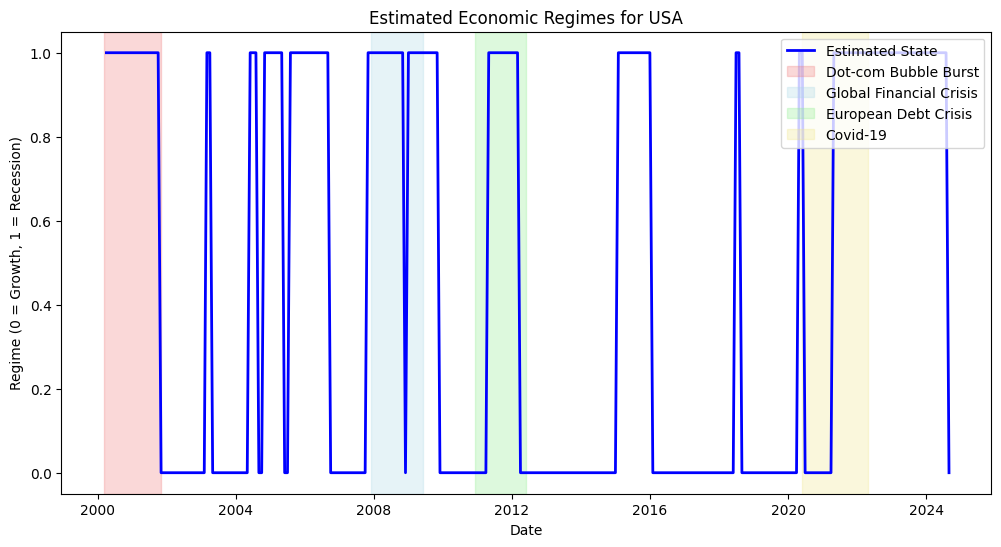

In [19]:
event_colors = ['lightcoral', 'lightblue', 'lightgreen', 'khaki', 'plum']  # Add more colors if needed


def plot_estimated_states(dates, estimated_states, events, country_name):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, estimated_states, label="Estimated State", color="blue", linewidth=2)
    
    # Highlight major financial events
    for i, event in enumerate(events):
        plt.axvspan(pd.to_datetime(event['start']), pd.to_datetime(event['end']), 
                    color=event_colors[i%len(event_colors)], alpha=0.3, label=event['name'])
    
    plt.title(f"Estimated Economic Regimes for {country_name}")
    plt.xlabel("Date")
    plt.ylabel("Regime (0 = Growth, 1 = Recession)")
    plt.legend(loc="upper right")
    plt.show()

# Example financial events
events = [
    {'name': 'Dot-com Bubble Burst', 'start': '2000-03-01', 'end': '2001-11-01'},
    {'name': 'Global Financial Crisis', 'start': '2007-12-01', 'end': '2009-06-01'},
    {'name': 'European Debt Crisis', 'start': '2010-12-01', 'end': '2012-06-01'},
    {'name': 'Covid-19', 'start': '2020-06-01', 'end': '2022-05-01'}
    # Add more events as needed
]

# Call the function with dates, estimated states, events, and country name
plot_estimated_states(dates=usa_data["Period"], estimated_states=USA_CPI_estimated_states, events=events, country_name="USA")

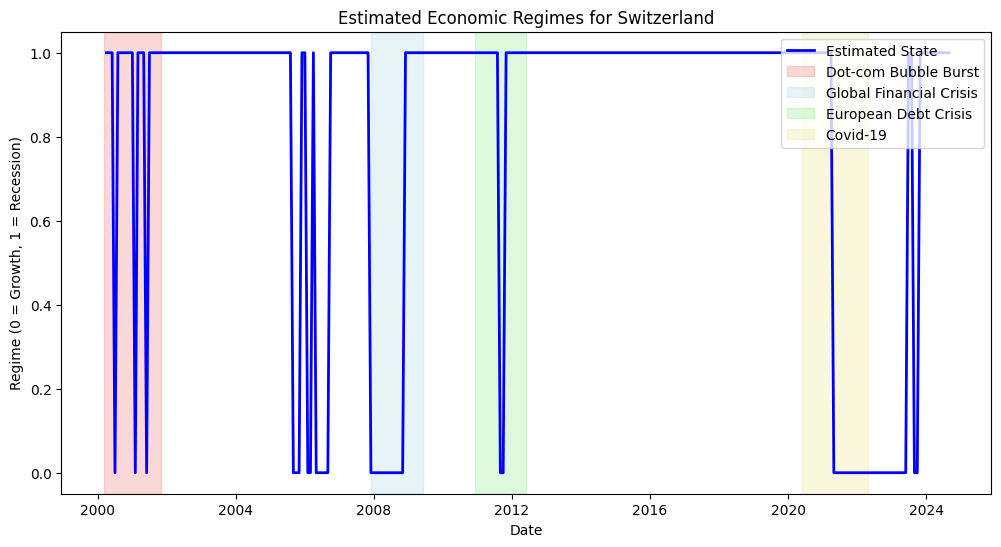

In [20]:
event_colors = ['lightcoral', 'lightblue', 'lightgreen', 'khaki', 'plum']  # Add more colors if needed


def plot_estimated_states(dates, estimated_states, events, country_name):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, estimated_states, label="Estimated State", color="blue", linewidth=2)
    
    # Highlight major financial events
    for i, event in enumerate(events):
        plt.axvspan(pd.to_datetime(event['start']), pd.to_datetime(event['end']), 
                    color=event_colors[i%len(event_colors)], alpha=0.3, label=event['name'])
    
    plt.title(f"Estimated Economic Regimes for {country_name}")
    plt.xlabel("Date")
    plt.ylabel("Regime (0 = Growth, 1 = Recession)")
    plt.legend(loc="upper right")
    plt.show()

# Example financial events
events = [
    {'name': 'Dot-com Bubble Burst', 'start': '2000-03-01', 'end': '2001-11-01'},
    {'name': 'Global Financial Crisis', 'start': '2007-12-01', 'end': '2009-06-01'},
    {'name': 'European Debt Crisis', 'start': '2010-12-01', 'end': '2012-06-01'},
    {'name': 'Covid-19', 'start': '2020-06-01', 'end': '2022-05-01'}
    # Add more events as needed
]

# Call the function with dates, estimated states, events, and country name
plot_estimated_states(dates=Switzerland_data["Period"], estimated_states=Switzerland_CPI_estimated_states, events=events, country_name="Switzerland")

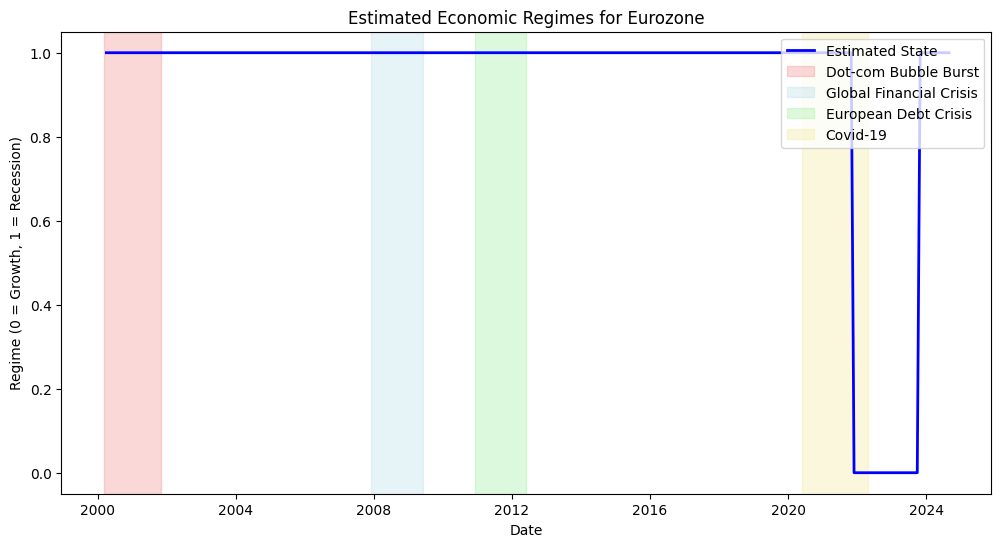

In [21]:
event_colors = ['lightcoral', 'lightblue', 'lightgreen', 'khaki', 'plum']  # Add more colors if needed


def plot_estimated_states(dates, estimated_states, events, country_name):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, estimated_states, label="Estimated State", color="blue", linewidth=2)
    
    # Highlight major financial events
    for i, event in enumerate(events):
        plt.axvspan(pd.to_datetime(event['start']), pd.to_datetime(event['end']), 
                    color=event_colors[i%len(event_colors)], alpha=0.3, label=event['name'])
    
    plt.title(f"Estimated Economic Regimes for {country_name}")
    plt.xlabel("Date")
    plt.ylabel("Regime (0 = Growth, 1 = Recession)")
    plt.legend(loc="upper right")
    plt.show()

# Example financial events
events = [
    {'name': 'Dot-com Bubble Burst', 'start': '2000-03-01', 'end': '2001-11-01'},
    {'name': 'Global Financial Crisis', 'start': '2007-12-01', 'end': '2009-06-01'},
    {'name': 'European Debt Crisis', 'start': '2010-12-01', 'end': '2012-06-01'},
    {'name': 'Covid-19', 'start': '2020-06-01', 'end': '2022-05-01'}
    # Add more events as needed
]

# Call the function with dates, estimated states, events, and country name
plot_estimated_states(dates=Eurozone_data["Period"], estimated_states=Eurozone_CPI_estimated_states, events=events, country_name="Eurozone")

In [22]:
USA_CPI_estimated_states

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0])

In [23]:
returns

,SMI,STOXX50,SP500
Date,,,
2024-10-28,0.011291,0.003994,-0.001613
2024-10-25,-0.004420,-0.005395,-0.002648
2024-10-24,-0.000900,-0.001547,0.000300
2024-10-23,-0.002133,-0.002617,-0.002143
2024-10-22,0.001335,0.003399,0.009234
...,...,...,...
2014-01-09,-0.008309,-0.004485,-0.002337
2014-01-08,0.006838,0.006580,-0.000326
2014-01-07,-0.004009,0.000096,0.000218


In [24]:
import pandas as pd
import numpy as np

# Assuming returnscopy DataFrame is already defined with dates from 2014-01-03 to 2024-10-28.

returnscopy = returns.copy()
# Ensure the index is in datetime format
returnscopy.index = pd.to_datetime(returnscopy.index)

# Define the starting month for our CPI states
start_date = '2014-01'
end_date = '2024-10'

# Create a date range for months from 2014-01 to 2024-10
months_range = pd.date_range(start=start_date, end=end_date, freq='M')

# Trim the CPI states arrays to match this range
us_states_trimmed = USA_CPI_estimated_states[-len(months_range):]
switzerland_states_trimmed = Switzerland_CPI_estimated_states[-len(months_range):]
eurozone_states_trimmed = Eurozone_CPI_estimated_states[-len(months_range):]

# Ensure the lengths match
assert len(months_range) == len(us_states_trimmed), "Mismatch in US states array length"
assert len(months_range) == len(switzerland_states_trimmed), "Mismatch in Switzerland states array length"
assert len(months_range) == len(eurozone_states_trimmed), "Mismatch in Eurozone states array length"

# Convert months_range to PeriodIndex to match the Month column type in returnscopy
months_period_index = months_range.to_period('M')

# Create states DataFrame
states_df = pd.DataFrame({
    'Month': months_period_index,
    'US_CPI_state': us_states_trimmed,
    'Switzerland_CPI_state': switzerland_states_trimmed,
    'Eurozone_CPI_state': eurozone_states_trimmed
})

# Create the 'Month' column in returnscopy based on its index
returnscopy['Month'] = returnscopy.index.to_period('M')

# Calculate daily volatilities using a 21-day rolling standard deviation
returnscopy['SMI_volatility'] = returnscopy['SMI'].rolling(window=21).std()
returnscopy['STOXX50_volatility'] = returnscopy['STOXX50'].rolling(window=21).std()
returnscopy['SP500_volatility'] = returnscopy['SP500'].rolling(window=21).std()

# Drop NaN values from the rolling calculations
returnscopy = returnscopy.dropna()

# Map each date in `returnscopy` to its monthly state by merging on the 'Month' column
returnscopy = returnscopy.merge(states_df, on='Month', how='left')

# Check for any remaining NaN values
print("Number of NaN values in CPI state columns:", returnscopy[['US_CPI_state', 'Switzerland_CPI_state', 'Eurozone_CPI_state']].isna().sum())



Number of NaN values in CPI state columns: US_CPI_state             0
Switzerland_CPI_state    0
Eurozone_CPI_state       0
dtype: int64


/var/folders/29/j6zpgq394917k8prm4sg190h0000gn/T/ipykernel_57838/934127079.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  months_range = pd.date_range(start=start_date, end=end_date, freq='M')


In [25]:
# Calculate average daily volatility for SMI conditioned on Switzerland CPI state
average_volatility_smi = returnscopy.groupby('Switzerland_CPI_state')['SMI_volatility'].mean()

# Calculate average daily volatility for STOXX50 conditioned on Eurozone CPI state
average_volatility_stoxx50 = returnscopy.groupby('Eurozone_CPI_state')['STOXX50_volatility'].mean()

# Calculate average daily volatility for SP500 conditioned on US CPI state
average_volatility_sp500 = returnscopy.groupby('US_CPI_state')['SP500_volatility'].mean()

# Combine the results into a single DataFrame for easy viewing
average_volatility_by_state = pd.DataFrame({
    'SMI_volatility': average_volatility_smi,
    'STOXX50_volatility': average_volatility_stoxx50,
    'SP500_volatility': average_volatility_sp500
})

# Display the result


In [26]:
# Add a region identifier to each DataFrame
usa_data['Region'] = 'USA'
Eurozone_data['Region'] = 'Eurozone'
Switzerland_data['Region'] = 'Switzerland'

# Concatenate the DataFrames along rows, aligning by columns
combined_data = pd.concat([usa_data, Eurozone_data, Switzerland_data], ignore_index=True)

In [27]:
combined_data

,GDP_YoY%,CPI_YoY%,Period,Region
0,0.0422,3.76,2000-03-31,USA
1,0.0422,3.07,2000-04-30,USA
2,0.0422,3.19,2000-05-31,USA
3,0.0524,3.73,2000-06-30,USA
4,0.0524,3.66,2000-07-31,USA
...,...,...,...,...
877,0.0074,1.37,2024-04-30,Switzerland
878,0.0074,1.39,2024-05-31,Switzerland
879,0.0169,1.33,2024-06-30,Switzerland
880,0.0169,1.29,2024-07-31,Switzerland


In [28]:
# Convert the 'Period' column in combined_data to a monthly period format
combined_data['MonthPeriod'] = combined_data['Period'].dt.to_period('M')

In [29]:
def online_particle_filter_step(Y_i, pi, A, emission_params, particles, weights, num_particles, ess_threshold=0.5):
    K = len(pi)

    ess = 1.0 / np.sum(weights ** 2)
    
    if ess < ess_threshold * num_particles:
        indices = np.random.choice(num_particles, size=num_particles, p=weights)
        particles = particles[indices]
        weights = np.ones(num_particles) / num_particles  
    
    # Predict step: sample next state for each particle
    particles = np.array([np.random.choice(K, p=A[particles[i]]) for i in range(num_particles)])
    
    # Update weights based on observation likelihood
    try:
        # Compute log-likelihoods to prevent underflow
        log_weights = norm.logpdf(
            Y_i, 
            loc=np.array([emission_params['mu'][p] for p in particles]), 
            scale=np.array([emission_params['sigma'][p] for p in particles])
        )
        # Handle -inf values
        log_weights = np.where(np.isfinite(log_weights), log_weights, -1e300)
        max_log_weight = np.max(log_weights)
        weights = np.exp(log_weights - max_log_weight)
        total_weight = np.sum(weights)
        if total_weight == 0 or np.isnan(total_weight):
            raise ValueError("Total weight is zero or NaN.")
        weights /= total_weight
    except Exception as e:
        print(f"Error in weight computation: {e}")
        # Reinitialize weights
        weights = np.ones(num_particles) / num_particles
    
    estimated_state = np.argmax(np.bincount(particles, weights=weights))
    
    return particles, weights, estimated_state


def simulate_gbm_with_particle_filtering(
    start_date, 
    pi,
    A,
    emission_params,
    n_simulations, 
    num_particles=200,
    verbose=False, 
    h_percentage_change={'SMI': 1.0, 'STOXX50': 1.0, 'SP500': 1.0}
):
    dt = 1 / 252
    sigma = {}
    
    risk_free_rate = r[r.index <= start_date].iloc[-1]
    
    corr_matrix = returns.corr()
    chol_matrix = np.linalg.cholesky(corr_matrix)
    
    n_timesteps = len(dates)
    
    Z = np.random.normal(size=(n_timesteps, n_simulations, 3))
    Z_flat = Z.reshape(-1, 3)
    Z_correlated_flat = Z_flat @ chol_matrix.T
    Z_correlated = Z_correlated_flat.reshape(n_timesteps, n_simulations, 3)
    
    initial_prices = {
        'SMI': smi[smi.index >= start_date]['Price'].iloc[-1],
        'STOXX50': stoxx50[stoxx50.index >= start_date]['Price'].iloc[-1],
        'SP500': sp500[sp500.index >= start_date]['Price'].iloc[-1]
    }
    
    price_paths = {
        'SMI': np.zeros((n_timesteps + 1, n_simulations)),
        'STOXX50': np.zeros((n_timesteps + 1, n_simulations)),
        'SP500': np.zeros((n_timesteps + 1, n_simulations))
    }
    
    for index in ['SMI', 'STOXX50', 'SP500']:
        price_paths[index][0] = initial_prices[index]

    # Initialize particles and weights for the particle filter (outside the time loop)
    particles_dict = {}
    weights_dict = {}
    for index in ['SMI', 'STOXX50', 'SP500']:
        particles_dict[index] = np.random.choice(len(pi[index]), size=num_particles, p=pi[index])
        weights_dict[index] = np.ones(num_particles) / num_particles
    
    estimated_states = {'SMI': [], 'STOXX50': [], 'SP500': []}
    n_timesteps = len(dates) - 1  # Ensure n_timesteps does not exceed the length of dates

    for i in range(1, n_timesteps + 1):
        current_date = dates[i]
        current_month = current_date.to_period('M')  # Convert to monthly period
        for idx, index in enumerate(['SMI', 'STOXX50', 'SP500']):
            # Map indices to regions
            region_map = {'SMI': 'Switzerland', 'STOXX50': 'Eurozone', 'SP500': 'USA'}
            region = region_map[index]
            
            # Get the CPI value for the current month and region from the combined_data DataFrame
            cpi_value = combined_data.loc[(combined_data['MonthPeriod'] == current_month) & 
                                        (combined_data['Region'] == region), 'CPI_YoY%'].values
            if len(cpi_value) > 0:
                Y_i = cpi_value[0]  # Use the CPI value as Y_i for this step
            else:
                # Handle missing data case if no CPI value exists for the date
                print(f"No CPI data for {current_month} in {region}")
                Y_i = np.nan
            
            # Ensure Y_i is valid before proceeding
            if not np.isnan(Y_i):
                # Perform particle filtering step
                particles_dict[index], weights_dict[index], estimated_state = online_particle_filter_step(
                    Y_i=Y_i,
                    pi=pi[index],
                    A=A[index],
                    emission_params=emission_params[index],
                    particles=particles_dict[index],
                    weights=weights_dict[index],
                    num_particles=num_particles
                )
                
                # Store the estimated state
                estimated_states[index].append(estimated_state)
                
                # Adjust mu and sigma based on the estimated state
                drift_term = (risk_free_rate - 0.5 * average_volatility_by_state[index+'_volatility'][estimated_state] ** 2) * dt
                diffusion_term = average_volatility_by_state[index+'_volatility'][estimated_state] * np.sqrt(dt) * Z_correlated[i - 1, :, idx]
                price_paths[index][i] = price_paths[index][i - 1] * np.exp(drift_term + diffusion_term)
            else:
                print(f"Skipping update for {current_date} due to missing CPI data.")
    
    # Transpose the price paths for easier handling and visualization
    for index in ['SMI', 'STOXX50', 'SP500']:
        price_paths[index] = price_paths[index].transpose()
    
    T = (final_date - start_date).days / 352
    if not verbose:
        return price_paths, estimated_states
    
    return price_paths, estimated_states

In [30]:
returns

,SMI,STOXX50,SP500
Date,,,
2024-10-28,0.011291,0.003994,-0.001613
2024-10-25,-0.004420,-0.005395,-0.002648
2024-10-24,-0.000900,-0.001547,0.000300
2024-10-23,-0.002133,-0.002617,-0.002143
2024-10-22,0.001335,0.003399,0.009234
...,...,...,...
2014-01-09,-0.008309,-0.004485,-0.002337
2014-01-08,0.006838,0.006580,-0.000326
2014-01-07,-0.004009,0.000096,0.000218


In [31]:
usa_data

,GDP_YoY%,CPI_YoY%,Period,Region
0,0.0422,3.76,2000-03-31,USA
1,0.0422,3.07,2000-04-30,USA
2,0.0422,3.19,2000-05-31,USA
3,0.0524,3.73,2000-06-30,USA
4,0.0524,3.66,2000-07-31,USA
...,...,...,...,...
289,0.0290,3.36,2024-04-30,USA
290,0.0290,3.27,2024-05-31,USA
291,0.0304,2.97,2024-06-30,USA
292,0.0304,2.89,2024-07-31,USA


In [32]:
def create_transition_matrices_dict(ASwitzerland, AEurozone, AUSA):
    transition_matrices = {
        'SMI': ASwitzerland,
        'STOXX50': AEurozone,
        'SP500': AUSA
    }
    return transition_matrices

def create_initial_state_distributions_dict(piSwitzerland, piEurozone, piUSA):
    initial_state_distributions = {
        'SMI': piSwitzerland,
        'STOXX50': piEurozone,
        'SP500': piUSA
    }
    return initial_state_distributions

def create_emission_params_dict(emission_params_Switzerland, emission_params_Eurozone, emission_params_USA):
    emission_params = {
        'SMI': emission_params_Switzerland,
        'STOXX50': emission_params_Eurozone,
        'SP500': emission_params_USA
    }
    return emission_params
A_dict = create_transition_matrices_dict(ASwitzerland, AEurozone, AUSA)
pi_dict = create_initial_state_distributions_dict(piSwitzerland, piEurozone, piUSA)
emission_params_dict = create_emission_params_dict(emission_params_Switzerland, emission_params_Eurozone, emission_params_USA)

In [33]:
final_date = pd.to_datetime('2024-09-26')
start_date = pd.to_datetime('2023-09-01')
dates = pd.bdate_range(start = start_date, end = '2024-01-01')
price_chart = pd.DataFrame({"Start_Date":[], "GBM_Mean_Price":[]})
nsim = 10000
for start_date in dates:
    price_paths, estimated_states = simulate_gbm_with_particle_filtering(start_date, n_simulations=nsim, pi = pi_dict, A= A_dict, emission_params=emission_params_dict)
    gbm_with_particle_filtering = price_barrier_reverse_convertible(start_date=start_date, price_paths=price_paths)

    
    price_chart.loc[len(price_chart)+1] = {"Start_Date": start_date, "GBM_Mean_Price": np.mean(gbm_with_particle_filtering)}
price_chart.set_index("Start_Date", inplace = True)


In [34]:
price_chart

,GBM_Mean_Price
Start_Date,
2023-09-01,97.478181
2023-09-04,97.478181
2023-09-05,97.425832
2023-09-06,97.408400
2023-09-07,97.425832
...,...
2023-12-26,73.580898
2023-12-27,49.307267
2023-12-28,49.298368


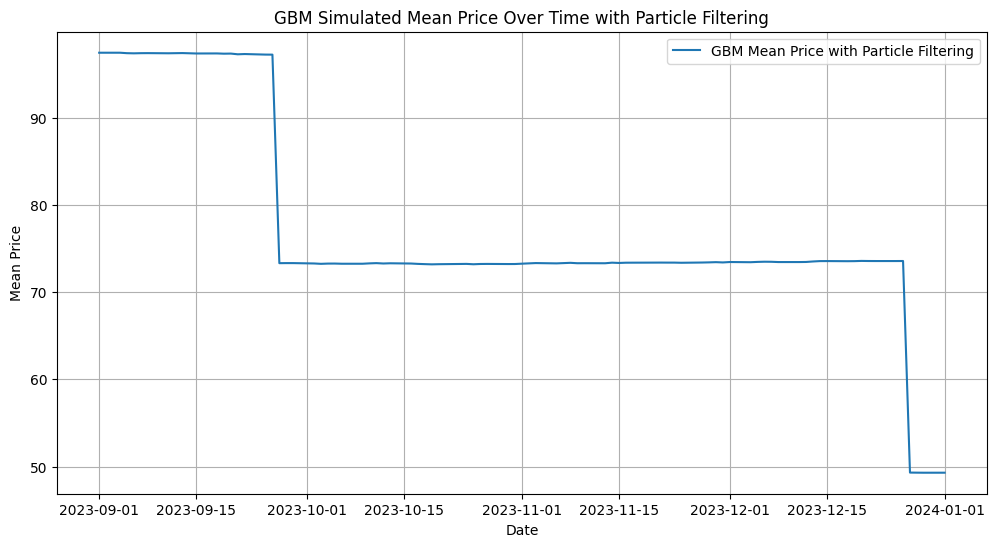

In [35]:
import matplotlib.pyplot as plt

# Assuming price_chart DataFrame has been populated
plt.figure(figsize=(12, 6))
plt.plot(price_chart.index, price_chart['GBM_Mean_Price'], label="GBM Mean Price with Particle Filtering")
plt.xlabel("Date")
plt.ylabel("Mean Price")
plt.title("GBM Simulated Mean Price Over Time with Particle Filtering")
plt.legend()
plt.grid(True)
plt.show()

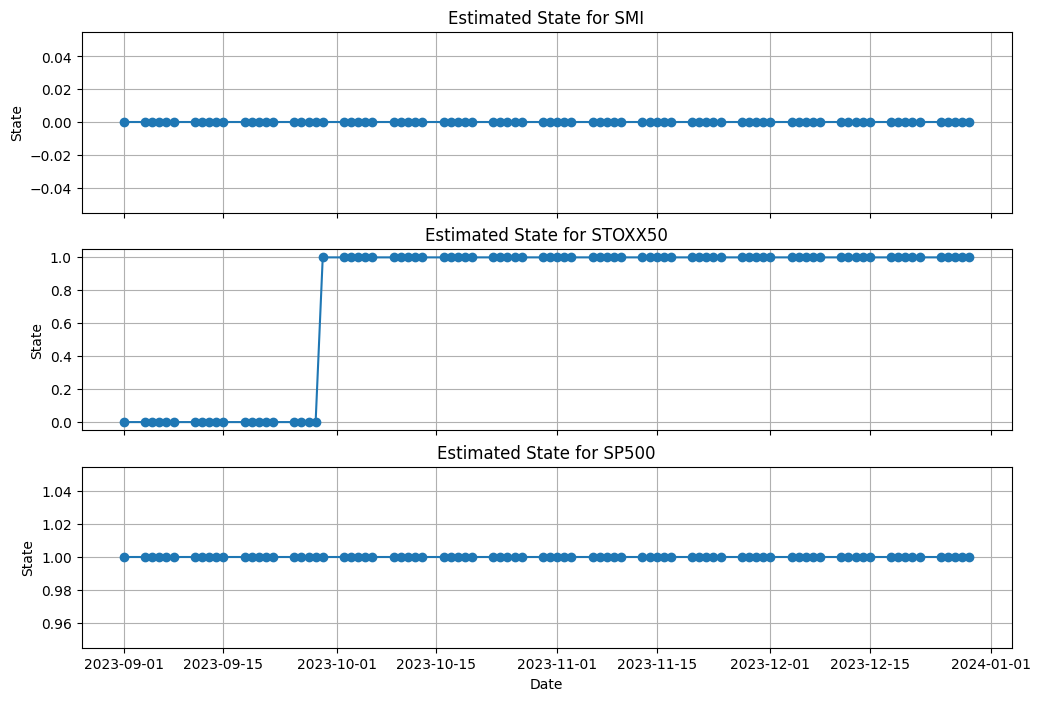

In [36]:
# Convert estimated_states to DataFrame for visualization
estimated_states_df = pd.DataFrame(estimated_states, index=dates[:len(estimated_states['SMI'])])

# Plot estimated states over time for each index
fig, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

for idx, index in enumerate(['SMI', 'STOXX50', 'SP500']):
    ax[idx].plot(estimated_states_df.index, estimated_states_df[index], marker='o', linestyle='-')
    ax[idx].set_title(f"Estimated State for {index}")
    ax[idx].set_ylabel("State")
    ax[idx].grid(True)

plt.xlabel("Date")
plt.show()

In [37]:
returns

,SMI,STOXX50,SP500
Date,,,
2024-10-28,0.011291,0.003994,-0.001613
2024-10-25,-0.004420,-0.005395,-0.002648
2024-10-24,-0.000900,-0.001547,0.000300
2024-10-23,-0.002133,-0.002617,-0.002143
2024-10-22,0.001335,0.003399,0.009234
...,...,...,...
2014-01-09,-0.008309,-0.004485,-0.002337
2014-01-08,0.006838,0.006580,-0.000326
2014-01-07,-0.004009,0.000096,0.000218
